In [57]:
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader

### Read Dataset

In [43]:
data = pd.read_csv('/kaggle/input/aiomodule6weather-forecast/dataset/weatherHistory.csv')
data.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [44]:
data_final = data.select_dtypes(float)
data_final = data_final.drop(columns = ['Apparent Temperature (C)'])
data_final.head()

,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
0,9.472222,0.89,14.1197,251.0,15.8263,0.0,1015.13
1,9.355556,0.86,14.2646,259.0,15.8263,0.0,1015.63
2,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94
3,8.288889,0.83,14.1036,269.0,15.8263,0.0,1016.41
4,8.755556,0.83,11.0446,259.0,15.8263,0.0,1016.51


In [45]:
data_final.values[:5]

array([[9.47222222e+00, 8.90000000e-01, 1.41197000e+01, 2.51000000e+02,
        1.58263000e+01, 0.00000000e+00, 1.01513000e+03],
       [9.35555556e+00, 8.60000000e-01, 1.42646000e+01, 2.59000000e+02,
        1.58263000e+01, 0.00000000e+00, 1.01563000e+03],
       [9.37777778e+00, 8.90000000e-01, 3.92840000e+00, 2.04000000e+02,
        1.49569000e+01, 0.00000000e+00, 1.01594000e+03],
       [8.28888889e+00, 8.30000000e-01, 1.41036000e+01, 2.69000000e+02,
        1.58263000e+01, 0.00000000e+00, 1.01641000e+03],
       [8.75555556e+00, 8.30000000e-01, 1.10446000e+01, 2.59000000e+02,
        1.58263000e+01, 0.00000000e+00, 1.01651000e+03]])

### Create Sequence From Dataset

In [46]:
def create_sequences(df, lag, ahead):
    features = []
    labels = []

    for i in range(len(df) -lag -ahead +1):
        feature = df.values[i:(i+lag)]
        label = df["Temperature (C)"].values[(i+lag):(i+lag+ahead)]

        features.append(feature)
        labels.append(label)

    return np.array(features), np.array(labels).squeeze()

X, y = create_sequences(data_final, 6, 1)
X.shape, y.shape

((96447, 6, 7), (96447,))

### Split dataset

In [47]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

features = X.tolist()
targets = y.tolist()

X_train, X_val, y_train, y_val = train_test_split(
    features, targets,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle
)

### Pytorch Dataset

In [48]:
import torch
from torch.utils.data import Dataset

class WeatherForecast(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        features = self.features[idx]
        targets = self.targets[idx]

        return torch.tensor(features, dtype = torch.float32), torch.tensor(targets, dtype = torch.float32)

In [49]:
train_dataset = WeatherForecast(
    X_train, 
    y_train,
)

val_dataset = WeatherForecast(
    X_val, 
    y_val,
)

test_dataset = WeatherForecast(
    X_test, 
    y_test,
)

In [50]:
sample_id = 2

# Check 0-th sample and dataset length
text0, label0 = train_dataset[sample_id]
print(f"Train 0-th sample - text shape: {text0.shape}, label: {label0}")
print(f"Train dataset length: {len(train_dataset)}")

text0_val, label0_val = val_dataset[sample_id]
print(f"Val 0-th sample - text shape: {text0_val.shape}, label: {label0_val}")
print(f"Val dataset length: {len(val_dataset)}")

text0_test, label0_test = test_dataset[sample_id]
print(f"Test 0-th sample - text shape: {text0_test.shape}, label: {label0_test}")
print(f"Test dataset length: {len(test_dataset)}")


Train 0-th sample - text shape: torch.Size([6, 7]), label: 9.872221946716309
Train dataset length: 67512
Val 0-th sample - text shape: torch.Size([6, 7]), label: 2.172222137451172
Val dataset length: 19290
Test 0-th sample - text shape: torch.Size([6, 7]), label: 5.205555438995361
Test dataset length: 9645


### Data Loader

In [51]:
test_batch_size = 64
train_batch_size = 128

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False,
)

### Build Transformer Model

In [52]:
class input_embeding(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.feature_emb = nn.Linear(7, d_model)
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.5)

    def positional_encoding(self, seq_len, d_model, device):
        position = torch.arange(seq_len, device=device).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2, device=device).float() *
                             -(math.log(10000.0) / d_model))
        pe = torch.zeros(seq_len, d_model, device=device)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe

    def forward(self, x):
        feats_emb = self.leakyrelu(self.feature_emb(x))
        B, L, D = feats_emb.shape
        device = x.device  # <- get device from input tensor
        positions_emb = self.positional_encoding(L, D, device)
        output = positions_emb + self.dropout(feats_emb)
        return output

In [53]:
class transformer_layer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim = d_model, 
                                          num_heads = num_heads,
                                         batch_first = True)
        self.ffn1 = nn.Linear(in_features = d_model,
                             out_features = ff_dim)
        self.ffn2 = nn.Linear(in_features = ff_dim,
                             out_features = d_model)
        
        self.leakyrelu = nn.LeakyReLU(0.1)

        self.layer_norm_1 = nn.LayerNorm(d_model)
        self.layer_norm_2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(0.5)

    def forward(self, Q, K, V):
        attn_output, _ = self.attn(Q, K, V)

        out1 = self.layer_norm_1(attn_output + Q)

        ffn_output = self.ffn2(self.dropout(self.leakyrelu(self.ffn1(out1))))

        out2 = self.layer_norm_2(out1 + ffn_output)
        
        return out2

In [54]:
class tranformer_model(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, num_layers):
        super().__init__()
        self.input_layer = input_embeding(d_model = d_model)

        list_tranformer_layers = [
            transformer_layer(
                d_model = d_model, 
                num_heads = num_heads, 
                ff_dim = ff_dim
            ) for _ in range(num_layers)
        ]
        self.transformer_layers = nn.ModuleList(list_tranformer_layers)

        self.global_pooling = nn.AdaptiveAvgPool1d(output_size=1)
        
        self.regressor = nn.Linear(d_model, 1)

    def forward(self, x):
        output = self.input_layer(x)
        for layer in self.transformer_layers:
            output = layer(output, output, output)
        output = self.global_pooling(output.transpose(1,2)).squeeze()
        output = self.regressor(output)

        return output

In [62]:
d_model = 128
num_heads = 4
ff_dim = 128
num_layers = 1

# Before calling tranformer_model
print(f"Type of d_model: {type(d_model)}, value: {d_model}")
print(f"Type of num_heads: {type(num_heads)}, value: {num_heads}")
print(f"Type of ff_dim: {type(ff_dim)}, value: {ff_dim}")
print(f"Type of num_layers: {type(num_layers)}, value: {num_layers}")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = tranformer_model(
    d_model = d_model, 
    num_heads = num_heads, 
    ff_dim = ff_dim, 
    num_layers = num_layers, 
)

Type of d_model: <class 'int'>, value: 128
Type of num_heads: <class 'int'>, value: 4
Type of ff_dim: <class 'int'>, value: 128
Type of num_layers: <class 'int'>, value: 1


In [63]:
from torchinfo import summary
summary(model, input_size=(10, 6, 7))  # seq_len=10, batch_size=6, input_size=7

Layer (type:depth-idx)                   Output Shape              Param #
tranformer_model                         [10, 1]                   --
├─input_embeding: 1-1                    [10, 6, 128]              --
│    └─Linear: 2-1                       [10, 6, 128]              1,024
│    └─LeakyReLU: 2-2                    [10, 6, 128]              --
│    └─Dropout: 2-3                      [10, 6, 128]              --
├─ModuleList: 1-2                        --                        --
│    └─transformer_layer: 2-4            [10, 6, 128]              --
│    │    └─MultiheadAttention: 3-1      [10, 6, 128]              66,048
│    │    └─LayerNorm: 3-2               [10, 6, 128]              256
│    │    └─Linear: 3-3                  [10, 6, 128]              16,512
│    │    └─LeakyReLU: 3-4               [10, 6, 128]              --
│    │    └─Dropout: 3-5                 [10, 6, 128]              --
│    │    └─Linear: 3-6                  [10, 6, 128]              16,512

# Training

In [64]:
import torch
import torch.nn as nn
from torchmetrics.regression import R2Score

def evaluate_model(model, val_loader, device=torch.device("cpu")):
    model.eval()

    r2_metric = R2Score().to(device)
    mse_loss_fn = nn.MSELoss(reduction='mean')

    total_loss = 0.0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).squeeze()

            # Update R2 metric
            r2_metric.update(outputs, targets)

            # Accumulate loss like in training
            loss = mse_loss_fn(outputs, targets)
            total_loss += loss.item()

    avg_mse = total_loss / len(val_loader)
    r2 = r2_metric.compute().item()

    return r2, avg_mse


evaluate_model(model, val_loader, device)

(-1.931711196899414, 264.77655463818684)

In [65]:
def train_model(model, train_loader, val_loader, num_epochs=20, lr=1e-3, device=torch.device("cpu")):
    model.train()
    
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()

    best_r2 = float('-inf')
    best_model_state = None

    # Lists to store metrics
    train_losses = []
    val_losses = []
    train_r2s = []
    val_r2s = []

    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0
        r2_metric_train = R2Score().to(device)

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            r2_metric_train.update(outputs, targets)

        avg_train_loss = epoch_loss / len(train_loader)
        train_r2 = r2_metric_train.compute().item()
        
        # Evaluate on validation set
        val_r2, val_mse = evaluate_model(model, val_loader, device)

        print(f"\nEpoch {epoch}/{num_epochs}")
        print(f"Train Loss: {avg_train_loss:.4f} | Train R²: {train_r2:.4f}")
        print(f"Val Loss: {val_mse:.4f} | Val R²: {val_r2:.4f}")
        
        # Save metrics
        train_losses.append(avg_train_loss)
        val_losses.append(val_mse)
        train_r2s.append(train_r2)
        val_r2s.append(val_r2)

        # Save best model based on validation R²
        if val_r2 > best_r2:
            best_r2 = val_r2
            best_model_state = model.state_dict()
            print("✅ Best model updated!")

    if best_model_state is not None:
        torch.save(best_model_state, "best_model.pth")
        print(f"\n✅ Best model saved with R² = {best_r2:.4f}")

    return train_losses, val_losses, train_r2s, val_r2s


In [71]:
d_model = 64
num_heads = 8
ff_dim = 128 
num_layers = 3

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = tranformer_model(
    d_model = d_model, 
    num_heads = num_heads, 
    ff_dim = ff_dim, 
    num_layers = num_layers, 
).to(device)

train_losses, val_losses, train_r2s, val_r2s = train_model(
    model, 
    train_loader, val_loader, 
    num_epochs=10, 
    lr=1e-3, 
    device=device)


Epoch 1/10
Train Loss: 97.6930 | Train R²: -0.0664
Val Loss: 90.3787 | Val R²: -0.0001
✅ Best model updated!

Epoch 2/10
Train Loss: 91.6468 | Train R²: -0.0005
Val Loss: 90.3805 | Val R²: -0.0001

Epoch 3/10
Train Loss: 91.5717 | Train R²: 0.0005
Val Loss: 90.2407 | Val R²: 0.0014
✅ Best model updated!

Epoch 4/10
Train Loss: 39.6307 | Train R²: 0.5672
Val Loss: 15.0865 | Val R²: 0.8331
✅ Best model updated!

Epoch 5/10
Train Loss: 17.3691 | Train R²: 0.8104
Val Loss: 14.4306 | Val R²: 0.8404
✅ Best model updated!

Epoch 6/10
Train Loss: 15.5725 | Train R²: 0.8300
Val Loss: 15.4094 | Val R²: 0.8296

Epoch 7/10
Train Loss: 14.7881 | Train R²: 0.8386
Val Loss: 14.0971 | Val R²: 0.8442
✅ Best model updated!

Epoch 8/10
Train Loss: 14.3744 | Train R²: 0.8431
Val Loss: 15.4861 | Val R²: 0.8288

Epoch 9/10
Train Loss: 14.2396 | Train R²: 0.8446
Val Loss: 17.7208 | Val R²: 0.8040

Epoch 10/10
Train Loss: 14.2082 | Train R²: 0.8449
Val Loss: 13.9938 | Val R²: 0.8453
✅ Best model updated!

✅ 

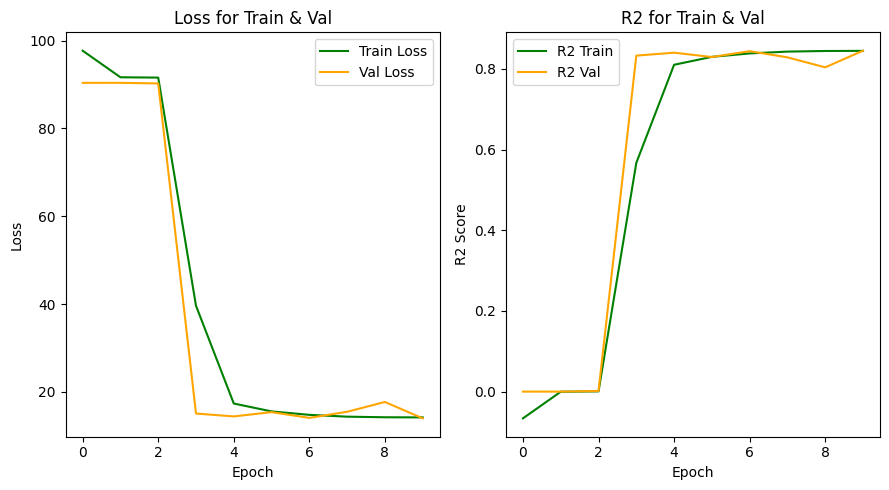

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(9, 5))
ax[0].plot(train_losses, color='green', label = 'Train Loss')
ax[0].plot(val_losses, color='orange', label = 'Val Loss')
ax[0].set(xlabel='Epoch', ylabel='Loss')
ax[0].set_title('Loss for Train & Val')
ax[0].legend()

ax[1].plot(train_r2s, color='green', label = 'R2 Train')
ax[1].plot(val_r2s, color='orange', label = 'R2 Val')
ax[1].set(xlabel='Epoch', ylabel='R2 Score')
ax[1].set_title('R2 for Train & Val')
ax[1].legend()

plt.tight_layout()

plt.show()

In [73]:
model.load_state_dict(torch.load("best_model.pth"))
evaluate_model(model, test_loader, device)

(0.8432081937789917, 14.170576635575452)